In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
%pip install bioinfokit
from bioinfokit.analys import stat
%pip install pingouin
from pingouin import ancova
%pip install dfply
from dfply import *

In [2]:
df = pd.read_csv('INF2178_A3_data.csv')

In [3]:
kindergarten = df.copy()
kindergarten.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


In [4]:
kindergarten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fallreadingscore             11933 non-null  float64
 1   fallmathscore                11933 non-null  float64
 2   fallgeneralknowledgescore    11933 non-null  float64
 3   springreadingscore           11933 non-null  float64
 4   springmathscore              11933 non-null  float64
 5   springgeneralknowledgescore  11933 non-null  float64
 6   totalhouseholdincome         11933 non-null  float64
 7   incomeinthousands            11933 non-null  float64
 8   incomegroup                  11933 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 839.2 KB


In [5]:
# assign income group as a categorical variable by transforming to type str
kindergarten['incomegroup'] = kindergarten['incomegroup'].astype(str)

# rename columns
new_col = ['Fall_Reading', 'Fall_Math', 'Fall_GeneralKnowledge', 'Spring_Reading',
           'Spring_Math', 'Spring_GeneralKnowledge', 'Household_Income', 'Income_Rounded',
           'Income_Group']
old_col = list(kindergarten)
name_dict = dict(map(lambda key, val: (key, val), old_col, new_col))
kindergarten = kindergarten.rename(columns=name_dict)

In [6]:
def round_p_val(val):
  if val < 0.001:
    val = '< 0.001'
  else:
    val = round(val, 3)
  return val

def round_table(df):
  rounded_df = df.copy()
  for col in rounded_df:
    if (rounded_df[col].dtype == 'float64') or (rounded_df[col].dtype == 'int64'):
      rounded_df[col] = rounded_df[col].apply(lambda x: round_p_val(x) if not math.isnan(x) else x)
  return rounded_df

In [7]:
# extract list of subjects and seasons
income_cat = sorted(list(kindergarten.Income_Group.unique()))
subjects = ['Reading', 'Math', 'GeneralKnowledge']
seasons = ['Fall', 'Spring']

# generate range of household income for each level of Income_Group for EDA
income_groups = kindergarten.pivot_table(index='Income_Group', values='Household_Income', aggfunc=['min', 'max'])
income_groups.columns = ['Min', 'Max']
income_groups

,Min,Max
Income_Group,,
1,1.0,39800.0
2,40000.0,69700.0
3,70000.0,150000.0


In [8]:
all_scores = kindergarten.iloc[:, :6]
income_data = kindergarten[['Income_Group']].copy()
scores_by_income = pd.concat([income_data, all_scores], axis=1)

In [9]:
# get summary statistics of all scores

def summary_table(df):
  summary_table = pd.DataFrame({'Statistic': ['Mean', 'Median', 'Min_Value', 'Max_Value', 'Quartile_1', 'Quartile_3']})
  for col in df:
    if df[col].dtypes != 'object':
      col_stats = [np.mean(df[col]), np.median(df[col]), df[col].min(),
                   df[col].max(), df[col].quantile(0.25), df[col].quantile(0.75)]
      summary_table[col] = col_stats
  summary_table = round_table(summary_table)
  return summary_table

summary_table(all_scores)

,Statistic,Fall_Reading,Fall_Math,Fall_GeneralKnowledge,Spring_Reading,Spring_Math,Spring_GeneralKnowledge
0,Mean,35.954,27.128,23.074,47.511,37.799,28.236
1,Median,34.060,25.680,22.954,45.320,36.410,28.583
2,Min_Value,21.010,10.510,6.985,22.350,11.900,7.858
3,Max_Value,138.510,115.650,47.691,156.850,113.800,48.345
4,Quartile_1,29.340,20.680,17.385,38.950,29.270,22.802
5,Quartile_3,39.890,31.590,28.305,51.770,44.220,33.782


In [10]:
# correlation of all scores to identify potential covariates
scores_cor = all_scores.corr()
round_table(scores_cor)

,Fall_Reading,Fall_Math,Fall_GeneralKnowledge,Spring_Reading,Spring_Math,Spring_GeneralKnowledge
Fall_Reading,1.000,0.706,0.488,0.832,0.632,0.472
Fall_Math,0.706,1.000,0.605,0.661,0.824,0.584
Fall_GeneralKnowledge,0.488,0.605,1.000,0.442,0.584,0.854
Spring_Reading,0.832,0.661,0.442,1.000,0.671,0.465
Spring_Math,0.632,0.824,0.584,0.671,1.000,0.609
Spring_GeneralKnowledge,0.472,0.584,0.854,0.465,0.609,1.000


## ANCOVA Part 1

In [11]:
# get df of all general knowledge scores
general_scores = scores_by_income[['Income_Group', 'Fall_GeneralKnowledge', 'Spring_GeneralKnowledge']].copy()
general_scores.columns = ['Income_Group'] + seasons
general_melt = general_scores.melt(id_vars='Income_Group', var_name= 'Season', value_name = 'Score', value_vars=seasons)

Text(0.5, 1.0, 'Distribution of General Knowledge Scores Across Income Groups')

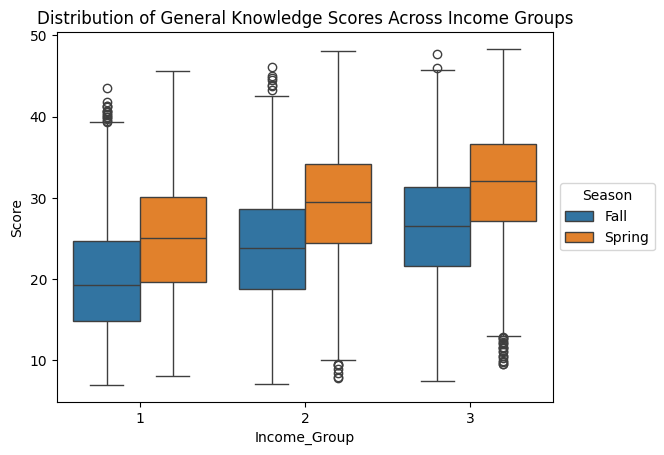

In [12]:
# visualize variation of each sample group
sns.boxplot(data=general_melt, x='Income_Group', order=income_cat, y='Score', hue='Season')
plt.legend(title='Season', loc='center left', bbox_to_anchor=[1, 0.5])
plt.title('Distribution of General Knowledge Scores Across Income Groups')

In [13]:
# summary statistics for dependent variable: spring score
spring_general_summary = general_scores >> group_by(X.Income_Group) >> summarize(n=X['Spring'].count(),
                                                       mean=X['Spring'].mean(),
                                                       std=X['Spring'].std())
round_table(spring_general_summary)

,Income_Group,n,mean,std
0,1,4729,25.069,7.248
1,2,3726,29.144,6.965
2,3,3478,31.568,6.928


In [14]:
# summary statistics for covariate: fall score
fall_general_summary = general_scores >> group_by(X.Income_Group) >> summarize(n=X['Fall'].count(),
                                                       mean=X['Fall'].mean(),
                                                       std=X['Fall'].std())
round_table(fall_general_summary)

,Income_Group,n,mean,std
0,1,4729,19.948,6.717
1,2,3726,23.888,6.870
2,3,3478,26.452,7.102


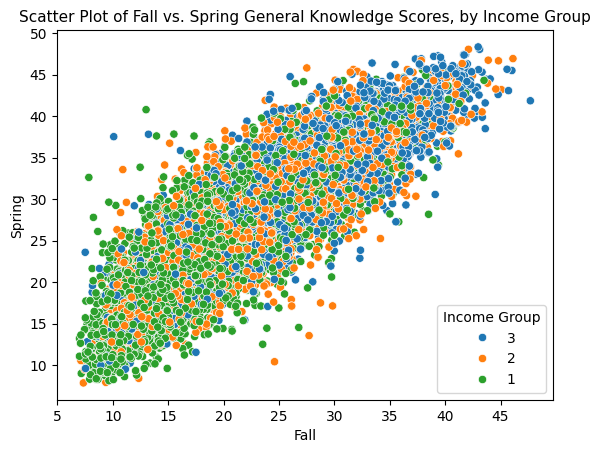

In [15]:
# test for correlation between dependent variable and covariate
sns.scatterplot(data=general_scores, x='Fall', y='Spring',
                hue='Income_Group')
plt.title('Scatter Plot of Fall vs. Spring General Knowledge Scores, by Income Group', fontsize=11)
plt.legend(title='Income Group')

In [16]:
# ancova
ancova_table = ancova(data=general_scores, dv='Spring', covar='Fall',
       between='Income_Group')
round_table(ancova_table)

,Source,SS,DF,F,p-unc,np2
0,Income_Group,1756.904,2,56.908,< 0.001,0.009
1,Fall,411876.768,1,26682.270,< 0.001,0.691
2,Residual,184140.180,11929,NaN,NaN,NaN


In [17]:
# fit the model
model = sm.formula.ols('Spring ~ Income_Group + Fall', data=general_scores).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spring   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:42   Log-Likelihood:                -33259.
No. Observations:               11933   AIC:                         6.653e+04
Df Residuals:                   11929   BIC:                         6.656e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.0303      0.11

In [18]:
# fit the model with interaction term
model_interaction = sm.formula.ols('Spring ~ Income_Group * Fall', data=general_scores).fit()

print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spring   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     6524.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:42   Log-Likelihood:                -33236.
No. Observations:               11933   AIC:                         6.648e+04
Df Residuals:                   11927   BIC:                         6.653e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

In [19]:
anova_table = sm.stats.anova_lm(model, typ=2)
round_table(anova_table)

,sum_sq,df,F,PR(>F)
Income_Group,1756.904,2.0,56.908,< 0.001
Fall,411876.768,1.0,26682.270,< 0.001
Residual,184140.180,11929.0,NaN,NaN


In [20]:
# post-hoc testing
res = stat()
res.tukey_hsd(df=general_scores, res_var='Spring', xfac_var='Income_Group', anova_model='Spring ~ C(Income_Group)')
round_table(res.tukey_summary)

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,3,2,2.424,2.033,2.815,20.571,0.001
1,3,1,6.498,6.128,6.868,58.205,0.001
2,2,1,4.074,3.711,4.437,37.212,0.001


Text(0.5, 1.0, 'Linear Regression Plot of Fall vs. Spring General Knowledge Scores')

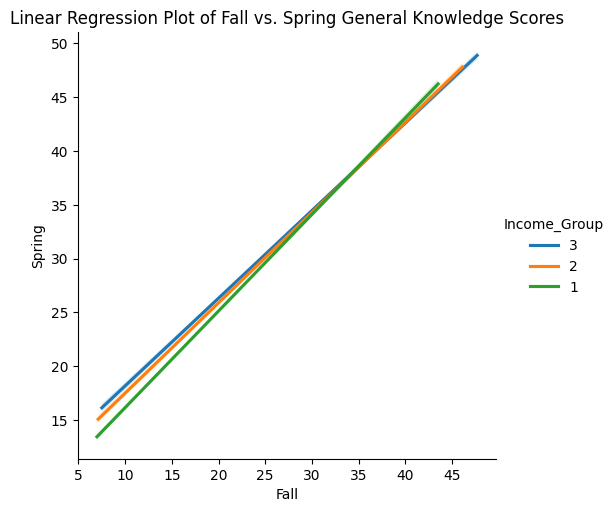

In [21]:
# test for linear relationship between dependent variable and covariate
sns.lmplot(data=general_scores, x='Fall', y='Spring', hue='Income_Group', scatter=False)
plt.title('Linear Regression Plot of Fall vs. Spring General Knowledge Scores')

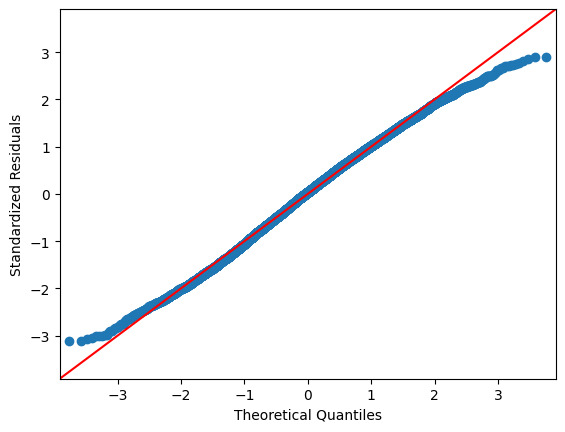

Text(0, 0.5, 'Frequency')

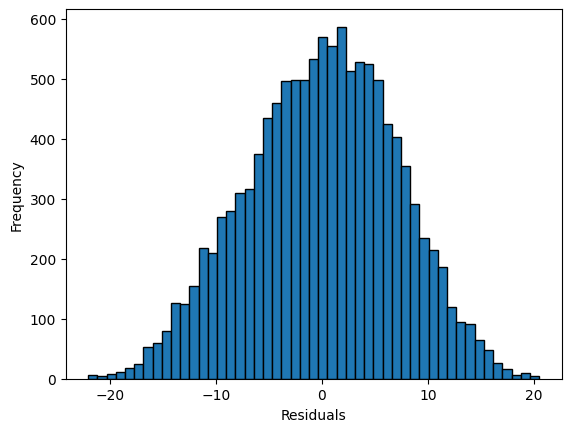

In [22]:
# test for normal distribution of residuals
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [23]:
# testing for homogeneity of variances
res = stat()
res.levene(df=general_scores, res_var='Spring', xfac_var='Income_Group')
round_table(res.levene_summary)

,Parameter,Value
0,Test statistics (W),9.406
1,Degrees of freedom (Df),2.0
2,p value,< 0.001


## ANCOVA Part 2

In [24]:
# get df of total scores (sum of all 3 subjects)
total_scores = kindergarten[['Income_Group']].copy()

for x in seasons:
  season_scores = [col for col in all_scores.columns if x in col]
  season_scores = all_scores[season_scores].sum(axis=1)
  total_scores[x] = season_scores

total_melt = total_scores.melt(id_vars='Income_Group', var_name= 'Season', value_name = 'Score', value_vars=seasons)

Text(0.5, 1.0, 'Distribution of Total Scores Across Income Groups')

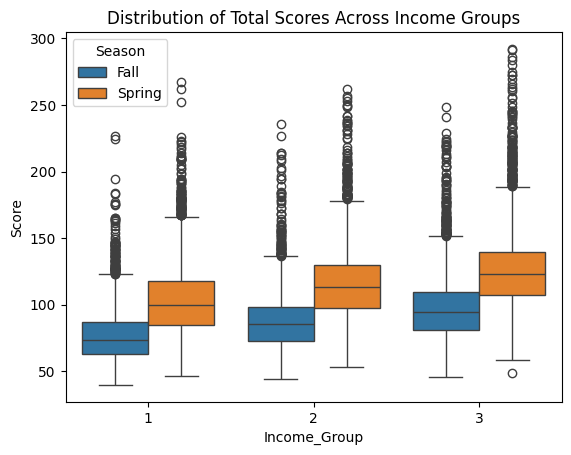

In [25]:
# visualize variation of each sample group
sns.boxplot(data=total_melt, x='Income_Group', order=income_cat, y='Score', hue='Season')
plt.title('Distribution of Total Scores Across Income Groups')

In [26]:
# summary statistics for dependent variable: spring score
spring_summary = total_scores >> group_by(X.Income_Group) >> summarize(n=X['Spring'].count(),
                                                       mean=X['Spring'].mean(),
                                                       std=X['Spring'].std())
round_table(spring_summary)

,Income_Group,n,mean,std
0,1,4729,102.618,25.765
1,2,3726,115.618,26.889
2,3,3478,126.186,30.241


In [27]:
# summary statistics for covariate: fall score
fall_summary = total_scores >> group_by(X.Income_Group) >> summarize(n=X['Fall'].count(),
                                                       mean=X['Fall'].mean(),
                                                       std=X['Fall'].std())
round_table(fall_summary)

,Income_Group,n,mean,std
0,1,4729,76.659,19.250
1,2,3726,87.749,21.342
2,3,3478,97.363,24.676


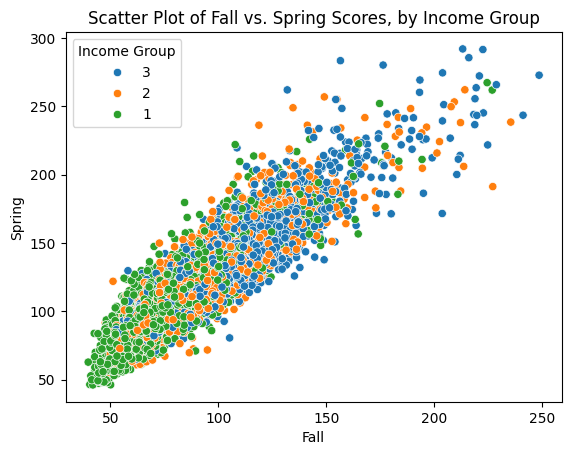

In [28]:
# test for correlation between dependent variable and covariate
sns.scatterplot(data=total_scores, x='Fall', y='Spring',
                hue='Income_Group')
plt.title('Scatter Plot of Fall vs. Spring Scores, by Income Group')
plt.legend(title='Income Group')

In [29]:
# ancova
ancova_table = ancova(data=total_scores, dv='Spring', covar='Fall', between='Income_Group')
round_table(ancova_table)

,Source,SS,DF,F,p-unc,np2
0,Income_Group,701.257,2,2.055,0.128,< 0.001
1,Fall,6976112.522,1,40883.557,< 0.001,0.774
2,Residual,2035489.362,11929,NaN,NaN,NaN


In [30]:
# fit the model
model = sm.formula.ols('Spring ~ Income_Group + Fall', data=total_scores).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spring   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 1.585e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:51   Log-Likelihood:                -47595.
No. Observations:               11933   AIC:                         9.520e+04
Df Residuals:                   11929   BIC:                         9.523e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.7952      0.46

In [31]:
# fit the model with interaction term
model_interaction = sm.formula.ols('Spring ~ Income_Group * Fall', data=total_scores).fit()

print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spring   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     9550.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:51   Log-Likelihood:                -47574.
No. Observations:               11933   AIC:                         9.516e+04
Df Residuals:                   11927   BIC:                         9.520e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12

In [32]:
anova_table = sm.stats.anova_lm(model, typ=2)
round_table(anova_table)

,sum_sq,df,F,PR(>F)
Income_Group,701.257,2.0,2.055,0.128
Fall,6976112.522,1.0,40883.557,< 0.001
Residual,2035489.362,11929.0,NaN,NaN


In [33]:
# post-hoc testing
res = stat()
res.tukey_hsd(df=total_scores, res_var='Spring', xfac_var='Income_Group', anova_model='Spring ~ C(Income_Group)')
round_table(res.tukey_summary)

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,3,2,10.569,9.050,12.088,23.065,0.001
1,3,1,23.569,22.130,25.008,54.291,0.001
2,2,1,13.000,11.589,14.411,30.537,0.001


Text(0.5, 1.0, 'Linear Regression Plot of Total Fall vs. Spring Scores')

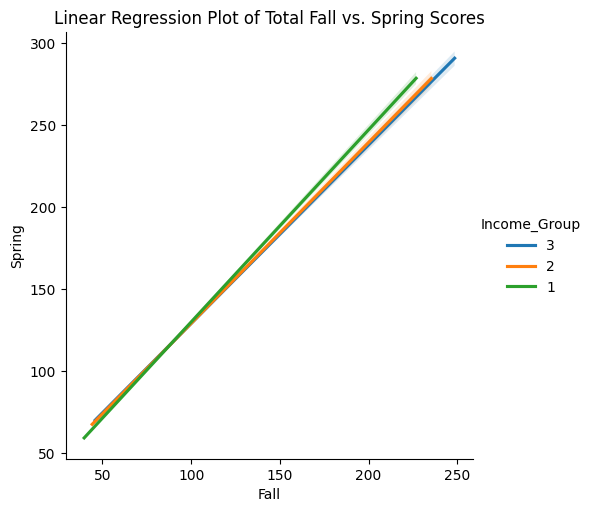

In [34]:
# test for linear relationship between dependent variable and covariate
sns.lmplot(data=total_scores, x='Fall', y='Spring', hue='Income_Group', scatter=False)
plt.title('Linear Regression Plot of Total Fall vs. Spring Scores')

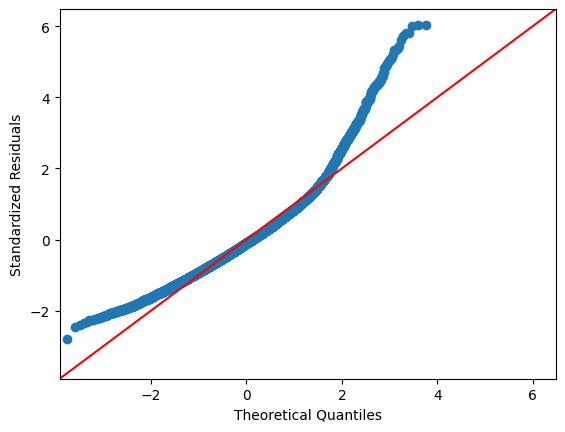

Text(0, 0.5, 'Frequency')

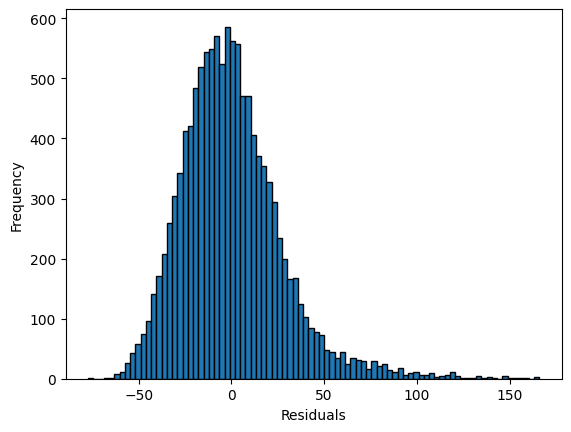

In [35]:
# test for normal distribution of the residuals
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [36]:
# testing for homogeneity of variances
res = stat()
res.levene(df=total_scores, res_var='Spring', xfac_var='Income_Group')
round_table(res.levene_summary)

,Parameter,Value
0,Test statistics (W),13.106
1,Degrees of freedom (Df),2.0
2,p value,< 0.001
